In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import timeit
import gc
import tensorflow as tf
from tensorflow import keras
import pickle

In [2]:
def run_als(R, F_p, k, weight = 0, reg_param = 0.05, epochs = 10):
    '''
        Users matrix - U, of shape k x u, where k is the number of latent features and u is the number of users
        Items matrix - V, of shape k x i, where i is the number of items.
        R - Explicit Rating matrix
        F_p - The positive filter matrix, used to extract observed interactions.
        F_n - The negative filter matrix, used to extract unobserved interactions.
    '''
    num_users = R.shape[0]
    num_items = R.shape[1]
    
    U = np.random.rand(k, num_users)
    V = np.random.rand(k, num_items)
    
    F_n = np.ones(shape = F_p.shape) - F_p
    
    for epoch in tqdm(range(epochs)):
        for user_idx, R_u in enumerate(R):
            filter_obs = np.diag(F_p[user_idx])
            filter_unobs = np.diag(F_n[user_idx])
            A = np.matmul(V, np.dot(filter_obs, V.T)) + weight * np.matmul(V, np.dot(filter_unobs, V.T)) + reg_param * np.eye(k)
            b = np.matmul(np.dot(V, filter_obs) + weight * np.dot(V, filter_unobs), R_u.T)
            
            U[:, user_idx] = np.linalg.solve(A, b)
        print('Fitted for users.')

        for item_idx, R_i in enumerate(R.T):
            filter_obs = np.diag(F_p.T[item_idx])
            filter_unobs = np.diag(F_n.T[item_idx])
            print(filter_obs.shape)
            print(U.shape)
            %timeit A = np.matmul(U, np.dot(filter_obs, U.T)) + weight * np.matmul(U, np.dot(filter_unobs, U.T)) + reg_param * np.eye(k)
            %timeit b = np.matmul(np.dot(U, filter_obs) + weight * np.dot(U, filter_unobs), R_i)
            
            V[:, item_idx] = np.linalg.solve(A, b)
            
            A = None
            b = None
            filter_obs = None
            filter_unobs = None
            gc.collect()
            return
        print('Fitted for items.')
    return U, V

In [3]:
dataset = pd.read_csv('ratings_Beauty.csv')

In [4]:
# Let's look at the ratings count of the products
gb_product = dataset.groupby('ProductId').size()
gb_product = gb_product.sort_values()

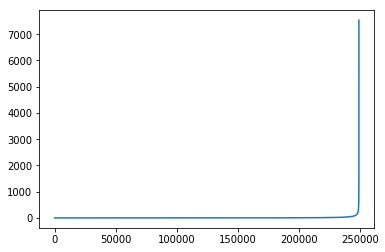

34


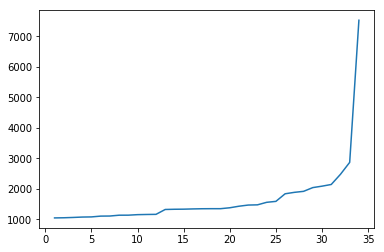

In [5]:
plt.plot(range(1, gb_product.shape[0] + 1), gb_product.values)
plt.show()
high_rated_products = gb_product[gb_product >= 1000]
plt.plot(range(1, high_rated_products.shape[0] + 1), high_rated_products.values)
print(high_rated_products.shape[0])

In [6]:
data_complete = dataset.loc[dataset['ProductId'].isin(high_rated_products.index)]
data = data_complete.iloc[:, :-1]

In [7]:
data_train, data_test, _, _ = train_test_split(data, np.zeros(data.shape[0]), test_size = 0.2)

In [ ]:
user_item_matrix_raw = pd.pivot_table(data_train, index = 'UserId', 
                                  columns = 'ProductId', values = 'Rating', aggfunc = np.sum)

In [ ]:
# Filling the NaN values with mean of the column
user_item_matrix = user_item_matrix_raw.fillna(-1)
user_item_matrix.head(4)

In [ ]:
def value_changer(value):
    if value > -1: return 1
    else: return 0
    
positive_filter = user_item_matrix.copy()
    
for row_index, row in positive_filter.iterrows():
    positive_filter.loc[row_index] = positive_filter.loc[row_index].apply(value_changer)

In [ ]:
with open('positive_filter.pkl', 'wb') as file:
    pickle.dump(positive_filter, file)
with open('user_item_matrix.pkl', 'wb') as file:
    pickle.dump(user_item_matrix, file)

In [ ]:
positive_filter = None
user_item_matrix = None
with open('positive_filter.pkl', 'rb') as file:
    positive_filter = pickle.load(file)
with open('user_item_matrix.pkl', 'rb') as file:
    user_item_matrix = pickle.load(file)

In [ ]:
U, V = run_als(user_item_matrix.values, positive_filter.values, k = 10, epochs = 2)

In [8]:
class NeuMF:
    def __init__(self, data, num_lf = 10, hidden_layers = 3, batch_size = 64):
        user_ids = list(data['UserId'])
        item_ids = list(data['ProductId'])
        
        self.num_users = len(user_ids)
        self.num_items = len(item_ids)
        self.num_lf = num_lf
        self.hidden_layers = hidden_layers
        self.batch_size = batch_size
        
        self.user_lookup = {}
        self.item_lookup = {}
        for idx in range(self.num_users):
            self.user_lookup[user_ids[idx]] = idx
        for idx in range(self.num_items):
            self.item_lookup[item_ids[idx]] = idx
        
        # Constructing the GMF part
        input_mf_user = keras.Input(shape = (1,), name = 'mf-user-input')
        input_mf_item = keras.Input(shape = (1,), name = 'mf-item-input')
        user_embedding_mf = keras.layers.Embedding(input_dim = self.num_users, output_dim = self.num_lf, input_length = 1)(input_mf_user)
        item_embedding_mf = keras.layers.Embedding(input_dim = self.num_items, output_dim = self.num_lf, input_length = 1)(input_mf_item)
        concat_mf = keras.layers.concatenate([user_embedding_mf, item_embedding_mf])
        mf_layer_one = keras.layers.Dense(units = 128, activation = 'linear')(concat_mf)
        
        # Constructing the MLP part
        input_mlp_user = keras.Input(shape = (1,), name = 'mlp-user-input')
        input_mlp_item = keras.Input(shape = (1,), name = 'mlp-item-input')
        user_embedding_mlp = keras.layers.Embedding(input_dim = self.num_users, output_dim = self.num_lf, input_length = 1)(input_mlp_user)
        item_embedding_mlp = keras.layers.Embedding(input_dim = self.num_items, output_dim = self.num_lf, input_length = 1)(input_mlp_item)
        concat_mlp = keras.layers.concatenate([user_embedding_mlp, item_embedding_mlp])
        mlp_layer_one = keras.layers.Dense(units = 128, activation = 'relu')(concat_mlp)
        mlp_layer_two = keras.layers.Dense(units = 64, activation = 'relu')(mlp_layer_one)
        mlp_layer_three = keras.layers.Dense(units = 64, activation = 'linear')(mlp_layer_two)
        
        # Constructing the combined part
        concat_mf_mlp = keras.layers.concatenate([mf_layer_one, mlp_layer_three])
        output_layer = keras.layers.Dense(units = self.batch_size, activation = 'linear', name = 'output-layer')(concat_mf_mlp)
        
        # Creating the model
        self.model = keras.Model(inputs = [input_mf_user, input_mf_item, input_mlp_user, input_mlp_item], 
                                 outputs = [output_layer], name = 'neural-collab-filtering')
        
    def forward(self, users, items, training = False):
        user_ids = np.array([self.user_lookup[user] for user in users]).reshape(-1, 1)
        item_ids = np.array([self.item_lookup[item] for item in items]).reshape(-1, 1)
        
        predictions = self.model({
            'mf-user-input': user_ids, 'mf-item-input': item_ids, 
            'mlp-user-input': user_ids, 'mlp-item-input': item_ids
        }, training = training)
        
        return predictions
    
    def train(self, train, validation = None, weight_unknown = 0.1, epochs = 5):
        def loss(ground_data, pred_data, filter_mask, anti_filter_mask):
            observed_loss_matrix = tf.math.multiply(tf.cast(filter_mask, dtype = tf.float32), 
                                                    (tf.cast(ground_data, dtype = tf.float32) - tf.cast(pred_data, dtype = tf.float32)))
            unobserved_loss_matrix = tf.math.multiply(tf.cast(anti_filter_mask, dtype = tf.float32), 
                                                      (tf.cast(ground_data, dtype = tf.float32) - tf.cast(pred_data, dtype = tf.float32)))

            return tf.add(tf.norm(observed_loss_matrix), weight_unknown * tf.norm(unobserved_loss_matrix))
        
        def grad(tape, ground_data, pred_data, filter_mask, anti_filter_mask):
            loss_value = loss(ground_data, pred_data, filter_mask, anti_filter_mask)
            gradients = tape.gradient(loss_value, self.model.trainable_variables)
            return loss_value, gradients
        
        def value_changer(value):
            if value == value and value != -1: return 1
            else: return 0
            
        def anti_value_changer(value):
            if value != value: return 1
            else: return 0
            
        def obtain_meta_data(ground_data):
            ground_data_master_matrix = pd.DataFrame(-1, index = range(self.batch_size), columns = range(self.batch_size))

            for row_idx in range(ground_data.shape[0]):
                for col_idx in range(ground_data.shape[1]):
                    ground_data_master_matrix.iloc[row_idx, col_idx] = ground_data.iloc[row_idx, col_idx]
                    
            filter_mask = ground_data_master_matrix.copy()
            anti_filter_mask = ground_data_master_matrix.copy()
                    
            for row_index, row in filter_mask.iterrows():
                filter_mask.loc[row_index] = filter_mask.loc[row_index].apply(value_changer)
            for row_index, row in anti_filter_mask.iterrows():
                anti_filter_mask.loc[row_index] = anti_filter_mask.loc[row_index].apply(anti_value_changer)
            
            ground_data_master_matrix = ground_data_master_matrix.fillna(3)
            ground_data_master_matrix = ground_data_master_matrix.replace(to_replace = -1, value = 0)
            
            filter_mask = tf.reshape(filter_mask.values, shape = [-1])
            anti_filter_mask = tf.reshape(anti_filter_mask.values, shape = [-1])
            ground_data = tf.reshape(ground_data_master_matrix.values, shape = [-1])
            
            return ground_data, filter_mask, anti_filter_mask
        
        history = []
        optimizer = keras.optimizers.Adam(learning_rate = 0.005)
        for epoch in range(epochs):
            stats = {'loss': 10}
            num_batches = train.shape[0] // self.batch_size
            
            start = 0
            for batch in tqdm(range(num_batches), desc = 'Epoch: {}/{}'.format(epoch, epochs)):
                with tf.GradientTape() as tape:
                    tape.watch(self.model.trainable_variables)
                    end = min(start + self.batch_size, train.shape[0])
                    batch_train = train.iloc[start : end]

                    ground_data = pd.pivot_table(batch_train, index = 'UserId', 
                                      columns = 'ProductId', values = 'Rating', aggfunc = np.average)
                    
                    flat_ratings, filter_mask, anti_filter_mask = obtain_meta_data(ground_data)

                    predictions = self.forward(users = batch_train['UserId'], items = batch_train['ProductId'], training = True)
                    predictions = tf.reshape(predictions, shape = [-1])

                    loss_value, grads = grad(tape, flat_ratings, predictions, filter_mask, anti_filter_mask)
                    optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
                
                stats['loss'] = loss_value
            print('Finished Epoch, loss: {}'.format(stats['loss']))
                

In [9]:
neu_mf = NeuMF(data_train)

In [ ]:
neu_mf.model.summary()

In [10]:
neu_mf.train(data_train, epochs = 1)

Epoch: 0/1: 100%|██████████| 704/704 [21:15<00:00,  1.81s/it]

Finished Epoch, loss: 0.3466905653476715
